## Final Project : Pavithra Senthilkumar USC ID: 8409-0854-94

# Transfer Learning for Image Classification

### Importing Libraries

In [3]:
pip install torch==2.2.2 torchvision==0.17.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 63.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [187]:
import pandas as pd
import numpy as np
# Core PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data handling
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# For image visualization (optional but helpful)
import matplotlib.pyplot as plt
import numpy as np

# For system path operations
import os

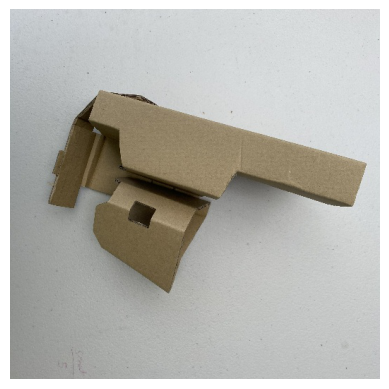

In [189]:
from PIL import Image
import matplotlib.pyplot as plt

# Load image
img = Image.open("../data/PDF Project/RealWaste/1-Cardboard/Cardboard_11.jpg")

# Visualize
plt.imshow(img)
plt.axis('off')  # Optional: turn off axes
plt.show()

## b) Data Exploration and Pre-processing

### Creating Train and Test Data and Splitting them

#### Images are numbered in each folder. Select the first 80% of the images in each folder as your training set and the rest as the test set. You can encode your classes using one-hot encoding.

#### In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [191]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

data_dir = '../data/PDF Project/RealWaste/'  # Base directory containing all class folders

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset from folder
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Number of samples
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split into train and test sets
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Class labels:", full_dataset.classes)


Class labels: ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']


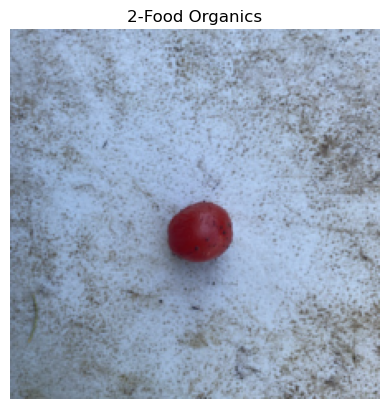

In [193]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))  # CHW → HWC
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)
imshow(images[0], full_dataset.classes[labels[0]])

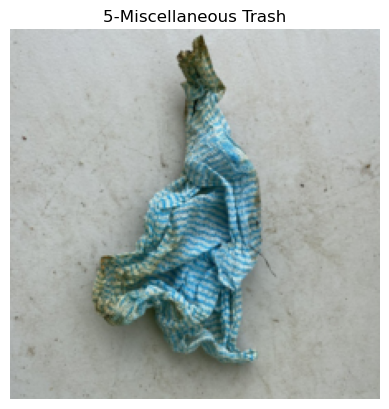

In [195]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
imshow(images[1], full_dataset.classes[labels[1]])

### Implementing Transformations

In [197]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [199]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

# Load datasets separately with transforms
full_dataset = ImageFolder(root=data_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Override test transform manually
test_dataset.dataset.transform = test_transform


### Loading Pretrained ResNet Model 

In [169]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier (fully connected layer)
num_classes = len(full_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [171]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

targets = np.array(full_dataset.targets)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

from torch.utils.data import Subset
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

# Apply test transforms to validation
val_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

### Defining Custom Head

In [174]:
import torch.nn.functional as F

class CustomHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(CustomHead, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        x = self.bn(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))  # ReLU activation
        return F.log_softmax(x, dim=1)  # Softmax + Log for cross-entropy

### Adding the Custom head for our task to ResNet

In [177]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_classes = len(full_dataset.classes)
model.fc = CustomHead(model.fc.in_features, num_classes)
model = model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [179]:
criterion = nn.NLLLoss()  # since we're using log_softmax
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-4)

In [27]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [29]:
from tqdm import tqdm

### Train Model

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100, patience=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Early Stopping Check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model_resnet.pth')  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    print("Training complete.")
    model.load_state_dict(best_model_wts)

    # Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.show()

    return model


Epoch 1/100


Train Loss: 0.9339 | Val Loss: 0.8959

Epoch 2/100


Train Loss: 0.9279 | Val Loss: 0.8675

Epoch 3/100


Train Loss: 0.9140 | Val Loss: 0.8367

Epoch 4/100


Train Loss: 0.9191 | Val Loss: 0.8406

Epoch 5/100


Train Loss: 0.9063 | Val Loss: 0.8567

Epoch 6/100


Train Loss: 0.9013 | Val Loss: 0.9109

Epoch 7/100


Train Loss: 0.9262 | Val Loss: 0.8517

Epoch 8/100


Train Loss: 0.8839 | Val Loss: 0.9223

Epoch 9/100


Train Loss: 0.8842 | Val Loss: 0.7741

Epoch 10/100


Train Loss: 0.9174 | Val Loss: 0.8742

Epoch 11/100


Train Loss: 0.8736 | Val Loss: 0.8320

Epoch 12/100


Train Loss: 0.8929 | Val Loss: 0.8093

Epoch 13/100


Train Loss: 0.8541 | Val Loss: 0.8093

Epoch 14/100


Train Loss: 0.8313 | Val Loss: 0.7510

Epoch 15/100


Train Loss: 0.8896 | Val Loss: 0.7813

Epoch 16/100


Train Loss: 0.8489 | Val Loss: 0.8276

Epoch 17/100


Train Loss: 0.8935 | Val Loss: 0.7948

Epoch 18/100


Train Loss: 0.8582 | Val Loss: 0.8035

Epoch 19/100


Train Loss: 0.8531 | Val Loss: 0.7634

Epoch 20/100


Train Loss: 0.8275 | Val Loss: 0.7469

Epoch 21/100


Train Loss: 0.8326 | Val Loss: 0.7593

Epoch 22/100


Train Loss: 0.8622 | Val Loss: 0.7524

Epoch 23/100


Train Loss: 0.8291 | Val Loss: 0.7974

Epoch 24/100


Train Loss: 0.8057 | Val Loss: 0.7481

Epoch 25/100


Train Loss: 0.8081 | Val Loss: 0.7468

Epoch 26/100


Train Loss: 0.7731 | Val Loss: 0.7831

Epoch 27/100


Train Loss: 0.7826 | Val Loss: 0.7200

Epoch 28/100


Train Loss: 0.7837 | Val Loss: 0.7143

Epoch 29/100


Train Loss: 0.8251 | Val Loss: 0.6837

Epoch 30/100


Train Loss: 0.7970 | Val Loss: 0.7703

Epoch 31/100


Train Loss: 0.8003 | Val Loss: 0.6966

Epoch 32/100


Train Loss: 0.8074 | Val Loss: 0.7478

Epoch 33/100


Train Loss: 0.7967 | Val Loss: 0.7321

Epoch 34/100


Train Loss: 0.7973 | Val Loss: 0.6903

Epoch 35/100


Train Loss: 0.7900 | Val Loss: 0.7733

Epoch 36/100


Train Loss: 0.7563 | Val Loss: 0.7274

Epoch 37/100


Train Loss: 0.7755 | Val Loss: 0.7025

Epoch 38/100


Train Loss: 0.7703 | Val Loss: 0.7045

Epoch 39/100


Train Loss: 0.8150 | Val Loss: 0.7372
Early stopping triggered!
Training complete.


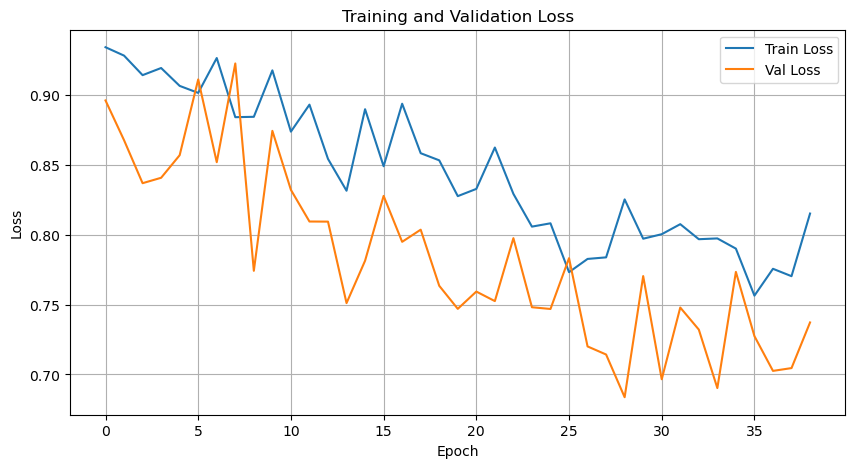

In [39]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100, patience = 10)

### Testing ResNet50 Model 

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [183]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F

def evaluate_model_with_auc(model, dataloader, device, class_names):
    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Apply softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_probs.extend(probabilities.cpu().numpy())

    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))

    # Compute AUC (macro-average)
    auc_score = roc_auc_score(y_true_bin, y_probs, average="macro", multi_class="ovr")

    print(f"\nMacro-Average ROC AUC Score: {auc_score:.4f}")


In [163]:
pwd

'/Users/pavithrasenthilkumar/Documents/School/DSML/Final_Project'

In [165]:
cd /Users/pavithrasenthilkumar/Documents/School/DSML/Final_Project/notebooks

/Users/pavithrasenthilkumar/Documents/School/DSML/Final_Project/notebooks


In [181]:
model.load_state_dict(torch.load('best_model_resnet.pth'))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Testing: 100%|██████████| 30/30 [05:14<00:00, 10.47s/it]



Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.99      0.70      0.82        97
      2-Food Organics       0.84      0.92      0.88        83
              3-Glass       0.88      0.85      0.86        93
              4-Metal       0.80      0.87      0.83       153
5-Miscellaneous Trash       0.73      0.77      0.75        90
              6-Paper       0.79      0.95      0.86        88
            7-Plastic       0.85      0.81      0.83       177
      8-Textile Trash       0.90      0.80      0.85        70
         9-Vegetation       0.92      0.96      0.94       100

             accuracy                           0.85       951
            macro avg       0.86      0.85      0.85       951
         weighted avg       0.85      0.85      0.84       951



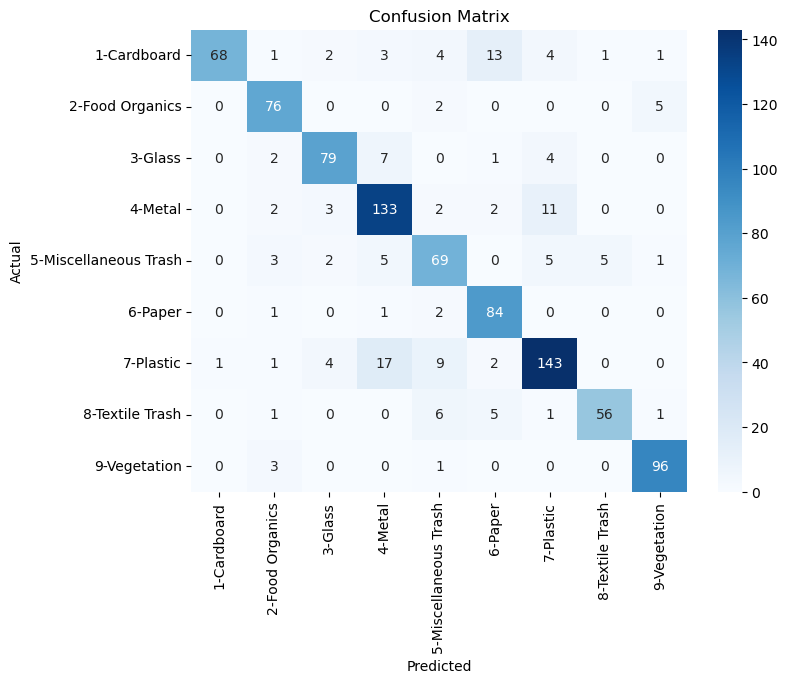

In [56]:
class_names = ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']
evaluate_model(model, test_loader, device, class_names)

In [201]:
class_names = ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']
evaluate_model_with_auc(model, test_loader, device, class_names)


Macro-Average ROC AUC Score: 0.9859


### ResNet50 Model Performance

#### ResNet50 has an Accuracy: 85% — This indicates strong overall performance on validation/test set.

#### Macro F1-score: 0.85 — Shows balanced performance across all classes, treating each class equally.

#### Weighted F1-score: 0.84 — Indicates good performance considering class imbalance.

### Training ResNet-100 / ResNet-101

In [203]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load ResNet101 pre-trained model
model = models.resnet101(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier (last layer) to match 9 classes
num_features = model.fc.in_features  # Accessing the number of input features to the final fully connected layer
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, 9)  # 9 classes for your dataset
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device,
                num_epochs=100, patience=10, save_path='best_model_resnet100.pth'):
    import copy
    import matplotlib.pyplot as plt
    from tqdm import tqdm

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training complete.")
    model.load_state_dict(best_model_wts)

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


Epoch 1/100


Train Loss: 1.3963 | Val Loss: 1.6214

Epoch 2/100


Train Loss: 1.0530 | Val Loss: 0.8501

Epoch 3/100


Train Loss: 0.9944 | Val Loss: 1.9795

Epoch 4/100


Train Loss: 0.9839 | Val Loss: 0.9207

Epoch 5/100


Train Loss: 0.9922 | Val Loss: 1.9108

Epoch 6/100


Train Loss: 0.9764 | Val Loss: 1.0755

Epoch 7/100


Train Loss: 0.9670 | Val Loss: 2.0148

Epoch 8/100


Train Loss: 0.9958 | Val Loss: 3.6349

Epoch 9/100


Train Loss: 0.9530 | Val Loss: 2.0256

Epoch 10/100


Train Loss: 0.9168 | Val Loss: 2.6391

Epoch 11/100


Train Loss: 0.9187 | Val Loss: 1.0382

Epoch 12/100


Train Loss: 0.9352 | Val Loss: 2.4238
Early stopping triggered.
Training complete.


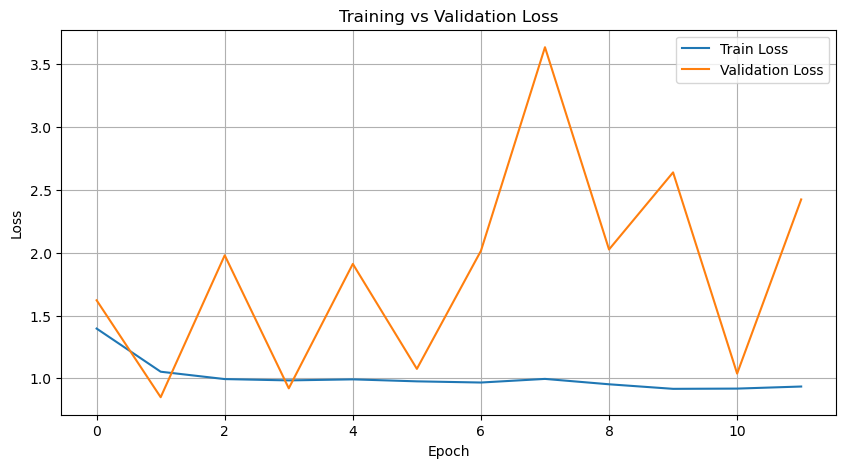

In [75]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100, patience=10)

### Testing ResNet101

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [79]:
model.load_state_dict(torch.load('best_model_resnet100.pth'))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Testing: 100%|██████████| 30/30 [08:08<00:00, 16.28s/it]



Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.74      0.69      0.71        97
      2-Food Organics       0.88      0.78      0.83        83
              3-Glass       0.72      0.56      0.63        93
              4-Metal       0.89      0.56      0.68       153
5-Miscellaneous Trash       0.41      0.81      0.54        90
              6-Paper       0.89      0.62      0.73        88
            7-Plastic       0.67      0.85      0.75       177
      8-Textile Trash       0.84      0.69      0.76        70
         9-Vegetation       0.94      0.88      0.91       100

             accuracy                           0.72       951
            macro avg       0.77      0.72      0.73       951
         weighted avg       0.77      0.72      0.73       951



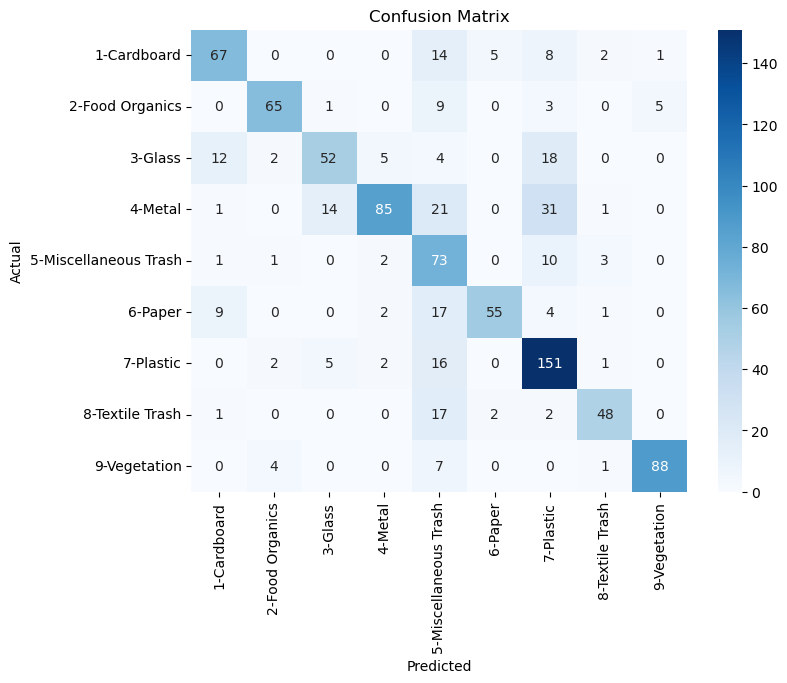

In [81]:
class_names = ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']
evaluate_model(model, test_loader, device, class_names)

In [205]:
class_names = ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']
evaluate_model_with_auc(model, test_loader, device, class_names)


Macro-Average ROC AUC Score: 0.4694


#### Accuracy: 72% — Significantly lower than ResNet50's 85%.

#### Macro F1-score: 0.73 vs. 0.85 (ResNet50) — Indicates a clear performance drop across most classes.

#### Weighted F1-score: 0.73 vs. 0.84 — Confirms that even weighted by class support, ResNet101 underperformed.

### Training EfficientNetB0

In [105]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load EfficientNetB0 pre-trained model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, 9)  # 9 classes for your dataset
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [107]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device,
                num_epochs=100, patience=10, save_path='best_model_efficientnetb0_1.pth'):
    import copy
    import matplotlib.pyplot as plt
    from tqdm import tqdm

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training complete.")
    model.load_state_dict(best_model_wts)

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


Epoch 1/100


Train Loss: 1.3551 | Val Loss: 1.0382

Epoch 2/100


Train Loss: 1.0573 | Val Loss: 0.8446

Epoch 3/100


Train Loss: 1.0015 | Val Loss: 0.7895

Epoch 4/100


Train Loss: 0.9490 | Val Loss: 0.8488

Epoch 5/100


Train Loss: 0.9207 | Val Loss: 0.8140

Epoch 6/100


Train Loss: 0.9039 | Val Loss: 0.7982

Epoch 7/100


Train Loss: 0.8856 | Val Loss: 0.7831

Epoch 8/100


Train Loss: 0.8839 | Val Loss: 0.7714

Epoch 9/100


Train Loss: 0.8717 | Val Loss: 0.8054

Epoch 10/100


Train Loss: 0.8682 | Val Loss: 0.7919

Epoch 11/100


Train Loss: 0.8256 | Val Loss: 0.7242

Epoch 12/100


Train Loss: 0.8480 | Val Loss: 0.7199

Epoch 13/100


Train Loss: 0.8335 | Val Loss: 0.7236

Epoch 14/100


Train Loss: 0.8407 | Val Loss: 0.7424

Epoch 15/100


Train Loss: 0.8064 | Val Loss: 0.7508

Epoch 16/100


Train Loss: 0.8062 | Val Loss: 0.7483

Epoch 17/100


Train Loss: 0.8054 | Val Loss: 0.7108

Epoch 18/100


Train Loss: 0.8009 | Val Loss: 0.7479

Epoch 19/100


Train Loss: 0.8185 | Val Loss: 0.7258

Epoch 20/100


Train Loss: 0.8156 | Val Loss: 0.7247

Epoch 21/100


Train Loss: 0.8477 | Val Loss: 0.7689

Epoch 22/100


Train Loss: 0.8013 | Val Loss: 0.7134

Epoch 23/100


Train Loss: 0.8214 | Val Loss: 0.7328

Epoch 24/100


Train Loss: 0.8158 | Val Loss: 0.7057

Epoch 25/100


Train Loss: 0.7979 | Val Loss: 0.7407

Epoch 26/100


Train Loss: 0.8161 | Val Loss: 0.7753

Epoch 27/100


Train Loss: 0.8373 | Val Loss: 0.7275

Epoch 28/100


Train Loss: 0.8090 | Val Loss: 0.7485

Epoch 29/100


Train Loss: 0.8137 | Val Loss: 0.7313

Epoch 30/100


Train Loss: 0.8034 | Val Loss: 0.6978

Epoch 31/100


Train Loss: 0.7785 | Val Loss: 0.7091

Epoch 32/100


Train Loss: 0.8127 | Val Loss: 0.8028

Epoch 33/100


Train Loss: 0.7972 | Val Loss: 0.7289

Epoch 34/100


Train Loss: 0.8142 | Val Loss: 0.7326

Epoch 35/100


Train Loss: 0.7794 | Val Loss: 0.7773

Epoch 36/100


Train Loss: 0.8046 | Val Loss: 0.7758

Epoch 37/100


Train Loss: 0.8105 | Val Loss: 0.8594

Epoch 38/100


Train Loss: 0.8021 | Val Loss: 0.7270

Epoch 39/100


Train Loss: 0.8257 | Val Loss: 0.7576

Epoch 40/100


Train Loss: 0.8048 | Val Loss: 0.7286
Early stopping triggered.
Training complete.


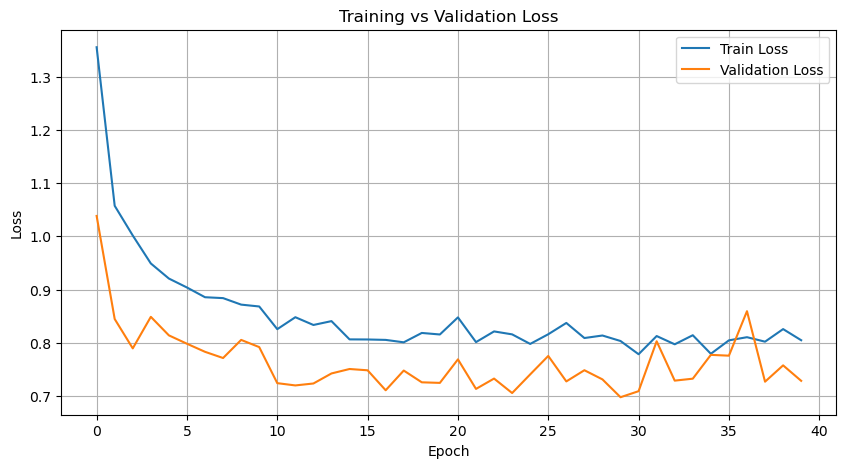

In [109]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100, patience=10)

### Testing EfficientNetB0

In [117]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [119]:
model.load_state_dict(torch.load('best_model_efficientnetb0_1.pth'))
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Testing: 100%|██████████| 30/30 [02:02<00:00,  4.08s/it]



Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.87      0.90      0.88        97
      2-Food Organics       0.96      0.88      0.92        83
              3-Glass       0.89      0.86      0.87        93
              4-Metal       0.83      0.86      0.85       153
5-Miscellaneous Trash       0.73      0.80      0.76        90
              6-Paper       0.85      0.82      0.83        88
            7-Plastic       0.82      0.82      0.82       177
      8-Textile Trash       0.92      0.84      0.88        70
         9-Vegetation       0.94      0.97      0.96       100

             accuracy                           0.86       951
            macro avg       0.87      0.86      0.86       951
         weighted avg       0.86      0.86      0.86       951



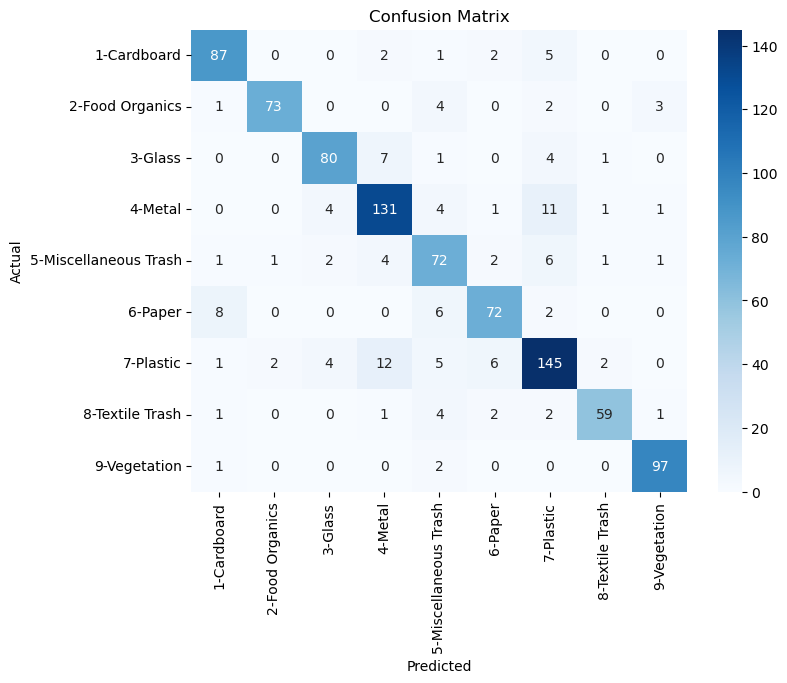

In [121]:
class_names = ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']
evaluate_model(model, test_loader, device, class_names)

#### Accuracy: 86% — Best so far among both the models - Resnet50, Resnet101

#### Macro F1-score: 0.86 — High and balanced across classes.

### Training VGG16

In [122]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load VGG16 pre-trained model
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[6].in_features  # Accessing the number of input features to the final fully connected layer
model.classifier[6] = nn.Linear(num_features, 9)  # 9 classes for your dataset

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/pavithrasenthilkumar/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 69.3MB/s] 


In [128]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device,
                num_epochs=100, patience=10, save_path='best_model_vgg16.pth'):
    import copy
    import matplotlib.pyplot as plt
    from tqdm import tqdm

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training complete.")
    model.load_state_dict(best_model_wts)

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


Epoch 1/100


Train Loss: 1.1737 | Val Loss: 0.9191

Epoch 2/100


Train Loss: 0.9570 | Val Loss: 0.9453

Epoch 3/100


Train Loss: 0.9396 | Val Loss: 0.8171

Epoch 4/100


Train Loss: 0.9471 | Val Loss: 0.8446

Epoch 5/100


Train Loss: 0.8859 | Val Loss: 0.8517

Epoch 6/100


Train Loss: 0.9179 | Val Loss: 0.8361

Epoch 7/100


Train Loss: 0.9047 | Val Loss: 0.8817

Epoch 8/100


Train Loss: 0.8823 | Val Loss: 0.8666

Epoch 9/100


Train Loss: 0.9004 | Val Loss: 0.8384

Epoch 10/100


Train Loss: 0.9141 | Val Loss: 0.7910

Epoch 11/100


Train Loss: 0.9337 | Val Loss: 0.8739

Epoch 12/100


Train Loss: 0.8956 | Val Loss: 0.9187

Epoch 13/100


Train Loss: 0.9183 | Val Loss: 0.8417

Epoch 14/100


Train Loss: 0.9337 | Val Loss: 0.8966

Epoch 15/100


Train Loss: 0.8801 | Val Loss: 0.8159

Epoch 16/100


Train Loss: 0.8634 | Val Loss: 0.7844

Epoch 17/100


Train Loss: 0.8938 | Val Loss: 0.9542

Epoch 18/100


Train Loss: 0.8714 | Val Loss: 0.8663

Epoch 19/100


Train Loss: 0.8553 | Val Loss: 0.8660

Epoch 20/100


Train Loss: 0.8670 | Val Loss: 0.8546

Epoch 21/100


Train Loss: 0.9037 | Val Loss: 0.9944

Epoch 22/100


Train Loss: 0.8907 | Val Loss: 0.9187

Epoch 23/100


Train Loss: 0.9257 | Val Loss: 0.8900

Epoch 24/100


Train Loss: 0.9144 | Val Loss: 0.8755

Epoch 25/100


Train Loss: 0.8808 | Val Loss: 0.9143

Epoch 26/100


Train Loss: 0.8756 | Val Loss: 0.8614
Early stopping triggered.
Training complete.


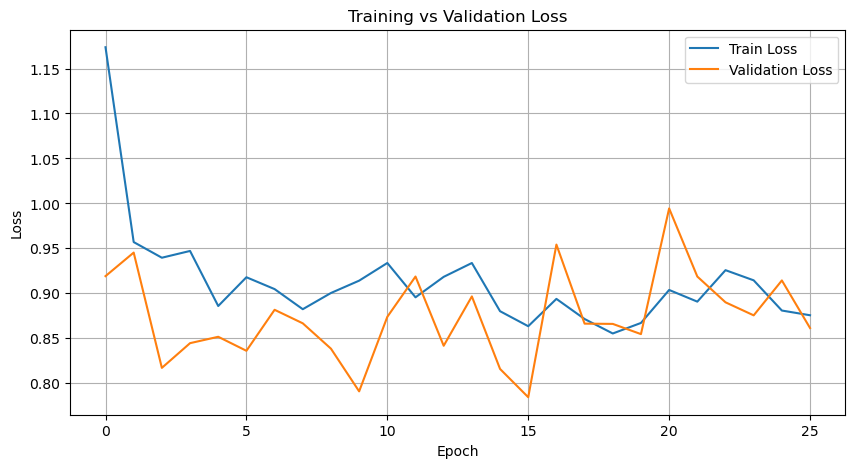

In [130]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001, weight_decay=1e-4)

# Train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100, patience=10)


### Testing VGG-16

In [131]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [132]:
model.load_state_dict(torch.load('best_model_vgg16.pth'))
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Testing: 100%|██████████| 30/30 [02:24<00:00,  4.83s/it]



Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.98      0.87      0.92        97
      2-Food Organics       0.93      0.95      0.94        83
              3-Glass       0.83      0.89      0.86        93
              4-Metal       0.92      0.87      0.90       153
5-Miscellaneous Trash       0.85      0.84      0.85        90
              6-Paper       0.85      0.98      0.91        88
            7-Plastic       0.86      0.89      0.88       177
      8-Textile Trash       0.93      0.81      0.87        70
         9-Vegetation       0.96      0.97      0.97       100

             accuracy                           0.90       951
            macro avg       0.90      0.90      0.90       951
         weighted avg       0.90      0.90      0.90       951



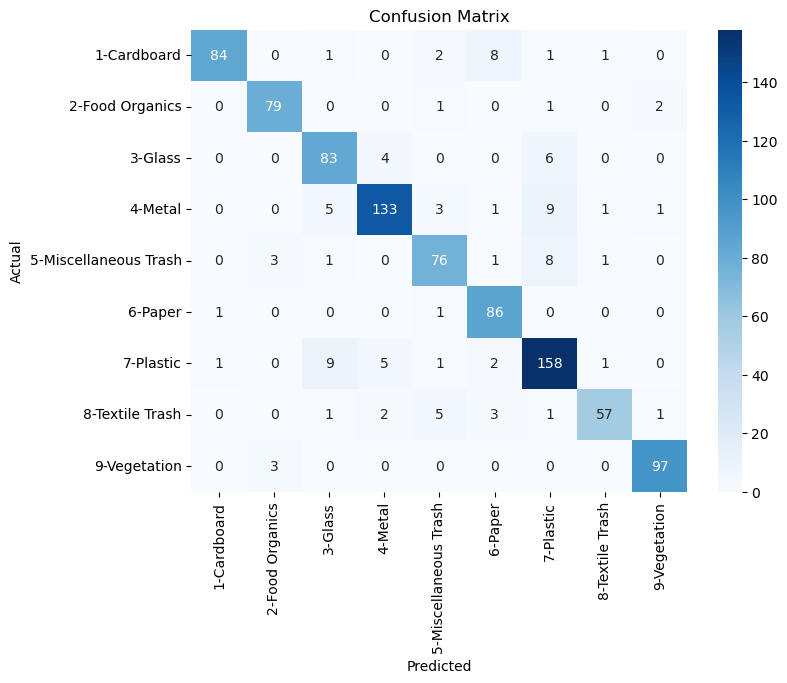

In [137]:
class_names = ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']
evaluate_model(model, test_loader, device, class_names)

### Conclusion:

#### V: Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem

#### Yes, in this multi-class classification problem, VGG16 clearly outperforms the other models (Resnet50, resnet101 and efficientnet). It achieves the highest accuracy (90%), along with the best macro and weighted F1-scores (both 0.90)


